In [25]:
import glob
import warnings
import tarfile
import cv2
import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from keras.layers import BatchNormalization, Activation, Conv2D
from keras.layers import GlobalAveragePooling2D, Lambda
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.optimizers import Adam, RMSprop
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import to_categorical, Sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
from keras.models import load_model, model_from_json
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from PIL import Image
from cv2 import resize
import tensorflow as tf
from keras.applications import ResNet50
from keras import regularizers
import requests
import threading
import random
import time
import urllib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import multi_gpu_model
from collections import Counter

%matplotlib inline

print('Keras version:', keras.__version__)
# print(os.listdir('SageMaker'))

warnings.simplefilter('default')
!pwd


Keras version: 2.2.4
/home/ec2-user/SageMaker


In [2]:
# n_cat = 203094
# batch_size = 64
# batch_size_predict = 128
# input_shape = (128,128)

train_path = './landmarks/train/train/'
test_path = './landmarks/test/test/'
train_images = glob.glob(train_path+'*.jpg')
test_images = glob.glob(test_path+'*.jpg')
print(len(train_images))
print(len(test_images))
sample_submission = pd.read_csv('./landmarks/recognition_sample_submission.csv')
sample_submission.shape

4130318
112821


(117703, 2)

In [3]:
train_image_ids = [image_file.replace(
    '.jpg', '').replace(train_path, '') for image_file in train_images]

train_df = pd.DataFrame(index=list(range(0,len(train_image_ids))))
train_df['filename'] = pd.Series(train_images, index=list(range(0,len(train_image_ids))))
train_df['ids'] = train_image_ids
test_image_ids = [image_file.replace(
    '.jpg', '').replace(test_path, '') for image_file in test_images]
test_df = pd.DataFrame(index=list(range(0,len(test_image_ids))))
test_df['filename'] = pd.Series(test_images, index=list(range(0,len(test_image_ids))))
test_df['ids'] = test_image_ids

In [4]:
def check_size(url):
    r = requests.get(url, stream=True)
    return int(r.headers['Content-Length'])

def download_file(url, filename, bar=True):
    """
    Helper method handling downloading large files from `url` to `filename`. Returns a pointer to `filename`.
    """
    try:
        chunkSize = 1024
        r = requests.get(url, stream=True)
        with open(filename, 'wb') as f:
            if bar:
                pbar = tqdm( unit="B", total=int( r.headers['Content-Length'] ) )
            for chunk in r.iter_content(chunk_size=chunkSize): 
                if chunk: # filter out keep-alive new chunks
                    if bar: 
                        pbar.update (len(chunk))
                    f.write(chunk)
        return filename
    except Exception as e:
        print(e)
        return
    
def download_image_cv2_urllib(url):
    """
    Modifying the url to download the 360p or 720p version actually slows it down. 
    """
    try:
        resp = urllib.request.urlopen(url)
        foo = np.asarray(bytearray(resp.read()), dtype="uint8")
        foo = cv2.imdecode(foo, cv2.IMREAD_COLOR)
        foo = cv2.resize(foo,(128, 128), interpolation=cv2.INTER_AREA)
        return foo
    except:
        return np.array([])


In [5]:
train = pd.read_csv("train.csv",index_col='id')
print(train.head())
print(train.shape)
print("Number of classes {}".format(len(train.landmark_id.unique())))

NUM_THRESHOLD = 420

counts = dict(Counter(train['landmark_id']))
landmarks_dict = {x:[] for x in train.landmark_id.unique() if counts[x] >= NUM_THRESHOLD}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

i = 0
landmark_to_idx = {}
idx_to_landmark = []
for k in landmarks_dict:
    landmark_to_idx[k] = i
    idx_to_landmark.append(k)
    i += 1
    
train['filename'] = pd.Series(train_images, index=train_image_ids)

all_urls = train['url'].tolist()
all_landmarks = train['landmark_id'].tolist()
valid_urls_dict = {x[0].split("/")[-1]:landmark_to_idx[x[1]] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict}
valid_urls_list = [x[0] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict]

NUM_EXAMPLES = len(valid_urls_list)
print("Total number of valid examples: {}".format(NUM_EXAMPLES)
     )

                                                                url  \
id                                                                    
6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

                  landmark_id  
id                             
6e158a47eb2ca3f6       142820  
202cd79556f30760       104169  
3ad87684c99c06e1        37914  
e7f70e9c61e66af3       102140  
4072182eddd0100e         2474  
(4132914, 2)
Number of classes 203094
Total number of valid classes: 339
Total number of valid examples: 252356


In [6]:
test_info_full = pd.read_csv('test.csv', index_col='id')
test_info_full.head()

test_info = test_info_full.loc[test_image_ids]
test_info['filename'] = pd.Series(test_images, index=test_image_ids)

test_info.head()

,url,filename
id,,
fa8d5a81a16f2f2f,https://lh3.googleusercontent.com/-_SAJTBt3Y64...,./landmarks/test/test/fa8d5a81a16f2f2f.jpg
b81a0a45f9b1ee97,https://lh3.googleusercontent.com/-9sFSIOCzIOs...,./landmarks/test/test/b81a0a45f9b1ee97.jpg
570e28cc63fab858,https://lh3.googleusercontent.com/-7Eld7yUfAB0...,./landmarks/test/test/570e28cc63fab858.jpg
b8bc63608b5fef1a,https://lh3.googleusercontent.com/-JdgzGjeS9NE...,./landmarks/test/test/b8bc63608b5fef1a.jpg
54cfd1f5f683b966,https://lh3.googleusercontent.com/-krCM7YZ3FpU...,./landmarks/test/test/54cfd1f5f683b966.jpg


In [27]:
landmark_subsample = pd.read_csv('topn_all_info.csv',index_col=['p0_landmark'])
landmark_subsample.head()

,filename,p0,p1,p2,p0_label,p1_label,p1_landmark,p2_label,p2_landmark,landmark_file,landmark_id
p0_landmark,,,,,,,,,,,
non-landmark,./landmarks/train/train/687c09f942938f4e.jpg,236,14,240,/m/museum/indoor,/a/archive,non-landmark,/n/nursery,non-landmark,687c09f942938f4e.jpg,198059
landmark,./landmarks/train/train/11704d4b86f8fe1a.jpg,309,76,234,/s/snowfield,/c/campsite,landmark,/m/mountain_snowy,landmark,11704d4b86f8fe1a.jpg,136542
non-landmark,./landmarks/train/train/67e34bedf25bd3d2.jpg,93,236,240,/c/clean_room,/m/museum/indoor,non-landmark,/n/nursery,non-landmark,67e34bedf25bd3d2.jpg,180256
landmark,./landmarks/train/train/05250fb79c967abb.jpg,190,187,186,/i/iceberg,/i/ice_shelf,landmark,/i/ice_floe,landmark,05250fb79c967abb.jpg,151989
landmark,./landmarks/train/train/ceb9fde5122403d6.jpg,296,183,107,/s/schoolhouse,/h/house,landmark,/c/cottage,landmark,ceb9fde5122403d6.jpg,151069


In [40]:
test = np.array(Image.open(train['filename'][1]))
test.shape

(171, 256, 3)

In [30]:
test.shape

AttributeError: 'JpegImageFile' object has no attribute 'shape'

In [8]:
landmark_confirmed = pd.DataFrame()
landmark_confirmed['filename'] = landmark_subsample['filename'].loc['landmark']
landmark_confirmed['landmark_id'] = landmark_subsample['landmark_id'].loc['landmark']
landmark_confirmed.reset_index(inplace=True)
landmark_confirmed.head(2)

,p0_landmark,filename,landmark_id
0,landmark,./landmarks/train/train/11704d4b86f8fe1a.jpg,136542
1,landmark,./landmarks/train/train/05250fb79c967abb.jpg,151989


In [9]:
non_landmark = pd.DataFrame()
non_landmark['filename'] = landmark_subsample['filename'].loc['non-landmark']
non_landmark['landmark_id'] = landmark_subsample['landmark_id'].loc['non-landmark']
non_landmark.reset_index(inplace=True)
non_landmark.head(2)

,p0_landmark,filename,landmark_id
0,non-landmark,./landmarks/train/train/687c09f942938f4e.jpg,198059
1,non-landmark,./landmarks/train/train/67e34bedf25bd3d2.jpg,180256


## These two datasets will be my validation datasets

In [10]:
n_cat = 203094 #number of unique classes (yikes)
input_shape = (128,128)
batch_size=48
batch_size_predict=128

In [11]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=True, n_values=n_cat)

train['label'] = label_encoder.fit_transform(train['landmark_id'].values)
train['one_hot'] = one_hot_encoder.fit_transform(
                    train['label'].values.reshape(-1, 1))

# Functions for preprocessing :

In [12]:
def load_images(info, input_shape = input_shape):
    input_shape = tuple(input_shape)
    imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))

    for i in range(len(info)):
        fname = info.iloc[i]['filename']
        try:
            img = cv2.cvtColor(
                  cv2.resize(cv2.imread(fname),input_shape),
                  cv2.COLOR_BGR2RGB)
        except:
            warnings.warn('Warning: could not read image: '+ fname +
                          '. Use black img instead.')
            img = np.zeros((input_shape[0], input_shape[1], 3))
        imgs[i,:,:,:] = img
    
    return imgs
def load_cropped_images(info, crop_p=0.2, crop='random'):
    new_res = np.array([int(input_shape[0]*(1+crop_p)), int(input_shape[1]*(1+crop_p))])
    if crop == 'random':
        cx0 = np.random.randint(new_res[0] - input_shape[0], size=len(info))
        cy0 = np.random.randint(new_res[1] - input_shape[1], size=len(info))
    else:
        if crop == 'central':
            cx0, cy0 = (new_res - input_shape) // 2                
        if crop == 'upper left':
            cx0, cy0 = 0, 0
        if crop == 'upper right':
            cx0, cy0 = new_res[1] - input_shape[1], 0
        if crop == 'lower left':
            cx0, cy0 = 0, new_res[0] - input_shape[0]
        if crop=='lower right':
            cx0, cy0 = new_res - input_shape        
        cx0 = np.repeat(np.expand_dims(cx0, 0), len(info))
        cy0 = np.repeat(np.expand_dims(cy0, 0), len(info))

    cx1 = cx0 + input_shape[0]
    cy1 = cy0 + input_shape[1]
    
    raw_imgs = load_images(info, input_shape=tuple(new_res))
    
    cropped_imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))
    for ind in range(len(info)):
        cropped_imgs[ind,:,:,:] = raw_imgs[ind,
                                           cy0[ind]:cy1[ind],
                                           cx0[ind]:cx1[ind], :]
    
    return cropped_imgs


def get_image_gen(info_arg, 
                  shuffle=True, 
                  image_aug=True, 
                  eq_dist=False, 
                  n_ref_imgs=16, 
                  crop_prob=0.2, 
                  crop_p=0.3):
    if image_aug:
        datagen = ImageDataGenerator(
            rotation_range=4.,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.5,
            channel_shift_range=25,
            horizontal_flip=True,
            fill_mode='nearest')
        
        if crop_prob > 0:
            datagen_crop = ImageDataGenerator(
                rotation_range=4.,
                shear_range=0.2,
                zoom_range=0.1,
                channel_shift_range=20,
                horizontal_flip=True,
                fill_mode='nearest')
        
    count = len(info_arg)
    
    while True:
        if eq_dist:
            def sample(df):
                return df.sample(min(n_ref_imgs, len(df)))
            info = info_arg.groupby('landmark_id', group_keys=False).apply(sample)
        else:
            info = info_arg
        print('Generate', len(info), 'for the next round.')
        
        #shuffle data
        if shuffle and count >= len(info):
            info = info.sample(frac=1)
            count = 0
            
        # load images
        for ind in range(0,len(info), batch_size):
            count += batch_size

            y = info['landmark_id'].values[ind:(ind+batch_size)]
            
            if np.random.rand() < crop_prob:
                imgs = load_cropped_images(info.iloc[ind:(ind+batch_size)], 
                                           crop_p=crop_p*np.random.rand() + 0.01, 
                                           crop='random')
                if image_aug:
                    cflow = datagen_crop.flow(imgs, 
                                              y, 
                                              batch_size=imgs.shape[0], 
                                              shuffle=False)
                    imgs, y = next(cflow)                    
            else:
                imgs = load_images(info.iloc[ind:(ind+batch_size)])
                if image_aug:
                    cflow = datagen.flow(imgs, 
                                       y, 
                                       batch_size=imgs.shape[0], 
                                       shuffle=False)
                    imgs, y = next(cflow)             

            imgs = preprocess_input(imgs)
    
            y_l = label_encoder.transform(y[y>=0.])        
            y_oh = np.zeros((len(y), n_cat))
            y_oh[y >= 0., :] = one_hot_encoder.transform(y_l.reshape(-1,1)).todense()
                    
            yield imgs, y_oh

def get_custom_loss(rank_weight=1., epsilon=1.e-9):
    def custom_loss(y_t, y_p):
        losses = tf.reduce_sum(-y_t*tf.log(y_p+epsilon) - (1.-y_t)*tf.log(1.-y_p+epsilon), 
                               axis=-1)
        
        pred_idx = tf.argmax(y_p, axis=-1)
        
        mask = tf.one_hot(pred_idx, 
                          depth=y_p.shape[1], 
                          dtype=tf.bool, 
                          on_value=True, 
                          off_value=False)
        pred_cat = tf.boolean_mask(y_p, mask)
        y_t_cat = tf.boolean_mask(y_t, mask)
        
        n_pred = tf.shape(pred_cat)[0]
        _, ranks = tf.nn.top_k(pred_cat, k=n_pred)
        
        ranks = tf.cast(n_pred-ranks, tf.float32)/tf.cast(n_pred, tf.float32)*rank_weight
        rank_losses = ranks*(-y_t_cat*tf.log(pred_cat+epsilon)
                             -(1.-y_t_cat)*tf.log(1.-pred_cat+epsilon))        
        
        return rank_losses + losses
    return custom_loss

def batch_GAP(y_t, y_p):
    pred_cat = tf.argmax(y_p, axis=-1)    
    y_t_cat = tf.argmax(y_t, axis=-1) * tf.cast(
        tf.reduce_sum(y_t, axis=-1), tf.int64)
    
    n_pred = tf.shape(pred_cat)[0]
    is_c = tf.cast(tf.equal(pred_cat, y_t_cat), tf.float32)

    GAP = tf.reduce_mean(
          tf.cumsum(is_c) * is_c / tf.cast(
              tf.range(1, n_pred + 1), 
              dtype=tf.float32))
    
    return GAP

def binary_crossentropy_n_cat(y_t, y_p):
    return keras.metrics.binary_crossentropy(y_t, y_p) * n_cat

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/preprocessing/image.py:440: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  image.ImageDataGenerator.__init__).args:


Generate 3927337 for the next round.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


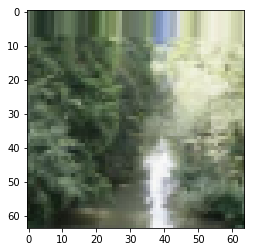

In [40]:
X_example, y_example = next(train_gen)
plt.imshow(X_example[1,:,:,:]/2. + 0.5)

In [26]:
K.clear_session()

In [ ]:
seed = 9
np.random.seed(seed=seed)
tf.set_random_seed(seed=seed)

# hyper parameters for model
nb_classes = 2  # number of classes
based_model_last_block_layer_number = 126  # value is based on based model selected.
img_width, img_height = 256, 256  # change based on the shape/structure of your images
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 50  # number of iteration the algorithm gets trained.
learn_rate = 1e-4  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum
transformation_ratio = .05  # how aggressive will be the data augmentation/transformation



def train(train_data_dir, validation_data_dir, model_path):
    # Pre-Trained CNN Model using imagenet dataset for pre-trained weights
    base_model = Xception(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False)

    # Top Model Block
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation='softmax')(x)

    # add your top layer block to your base model
    model = Model(base_model.input, predictions)
    print(model.summary())

    # # let's visualize layer names and layer indices to see how many layers/blocks to re-train
    # # uncomment when choosing based_model_last_block_layer
    # for i, layer in enumerate(model.layers):
    #     print(i, layer.name)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all layers of the based model that is already pre-trained.
    for layer in base_model.layers:
        layer.trainable = False

    # Read Data and Augment it: Make sure to select augmentations that are appropriate to your images.
    # To save augmentations un-comment save lines and add to your flow parameters.
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=transformation_ratio,
                                       shear_range=transformation_ratio,
                                       zoom_range=transformation_ratio,
                                       cval=transformation_ratio,
                                       horizontal_flip=True,
                                       vertical_flip=True)

    validation_datagen = ImageDataGenerator(rescale=1. / 255)

    os.makedirs(os.path.join(os.path.abspath(train_data_dir), '../preview'), exist_ok=True)
    train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')
    # save_to_dir=os.path.join(os.path.abspath(train_data_dir), '../preview')
    # save_prefix='aug',
    # save_format='jpeg')
    # use the above 3 commented lines if you want to save and look at how the data augmentations look like

    validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                                  target_size=(img_width, img_height),
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical')

    model.compile(optimizer='nadam',
                  loss='categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
                  metrics=['accuracy'])

    # save weights of best training epoch: monitor either val_loss or val_acc

    top_weights_path = os.path.join(os.path.abspath(model_path), 'top_model_weights.h5')
    callbacks_list = [
        ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_acc', patience=5, verbose=0)
    ]

    # Train Simple CNN
    model.fit_generator(train_generator,
                        samples_per_epoch=train_generator.nb_sample,
                        nb_epoch=nb_epoch / 5,
                        validation_data=validation_generator,
                        nb_val_samples=validation_generator.nb_sample,
                        callbacks=callbacks_list)

    # verbose
    print("\nStarting to Fine Tune Model\n")

    # add the best weights from the train top model
    # at this point we have the pre-train weights of the base model and the trained weight of the new/added top model
    # we re-load model weights to ensure the best epoch is selected and not the last one.
    model.load_weights(top_weights_path)

    # based_model_last_block_layer_number points to the layer in your model you want to train.
    # For example if you want to train the last block of a 19 layer VGG16 model this should be 15
    # If you want to train the last Two blocks of an Inception model it should be 172
    # layers before this number will used the pre-trained weights, layers above and including this number
    # will be re-trained based on the new data.
    for layer in model.layers[:based_model_last_block_layer_number]:
        layer.trainable = False
    for layer in model.layers[based_model_last_block_layer_number:]:
        layer.trainable = True

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(optimizer='nadam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # save weights of best training epoch: monitor either val_loss or val_acc
    final_weights_path = os.path.join(os.path.abspath(model_path), 'model_weights.h5')
    callbacks_list = [
        ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    ]

    # fine-tune the model
    model.fit_generator(train_generator,
                        samples_per_epoch=train_generator.nb_sample,
                        nb_epoch=nb_epoch,
                        validation_data=validation_generator,
                        nb_val_samples=validation_generator.nb_sample,
                        callbacks=callbacks_list)

    # save model
    model_json = model.to_json()
    with open(os.path.join(os.path.abspath(model_path), 'model.json'), 'w') as json_file:
        json_file.write(model_json)

In [14]:
x_model = Xception(input_shape=list(input_shape) + [3], 
                   weights='imagenet', 
                   include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
x_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [16]:
print((x_model.layers[85]).name)
print((x_model.layers[25]).name)
print((x_model.layers[15]).name)

add_8
add_2
add_1


In [17]:
for layer in x_model.layers:
    layer.trainable = True

for layer in x_model.layers[:85]:
    layer.trainable = False   
    
x_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [18]:
model = multi_gpu_model(x_model,gpus=8)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

In [21]:
opt = Adam(lr=0.0001)
loss = get_custom_loss(1.0)
#loss='categorical_crossentropy'
#loss='binary_crossentropy'
model.compile(loss=loss, 
              optimizer=opt, 
              metrics=['accuracy'])

ValueError: Shapes (?, 4, 4, 2048) and (?, 4, 4, 4) are incompatible

# the following code is for GAP

In [49]:
# gm_exp = tf.Variable(3., dtype=tf.float32)
# def generalized_mean_pool_2d(X):
#     pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
#                            axis=[1,2], 
#                            keepdims=False)+1.e-8)**(1./gm_exp)
#     return pool

In [22]:
# X_feat = Input(x_model.output_shape[1:])

# lambda_layer = Lambda(generalized_mean_pool_2d)
# lambda_layer.trainable_weights.extend([gm_exp])
# X = lambda_layer(X_feat)
# X = Dropout(0.05)(X)
# X = Activation('relu')(X)
# X = Dense(n_cat, activation='softmax')(X)

# top_model = Model(inputs=X_feat, outputs=X)
# top_model.summary()

In [ ]:
# X_image = Input(list(input_shape) + [3])

# X_f = x_model(X_image)
# X_f = top_model(X_f)

# model = Model(inputs=X_image, outputs=X_f)
# model.summary()

In [52]:
# opt = Adam(lr=0.0001)
# loss = get_custom_loss(1.0)
# #loss='categorical_crossentropy'
# #loss='binary_crossentropy'
# model.compile(loss=loss, 
#               optimizer=opt, 
#               metrics=[binary_crossentropy_n_cat, 'accuracy', batch_GAP])

In [53]:
checkpoint1 = ModelCheckpoint('dd_checkpoint-1.h5', 
                              period=1, 
                              verbose=1, 
                              save_weights_only=True)
checkpoint2 = ModelCheckpoint('dd_checkpoint-2.h5', 
                              period=1, 
                              verbose=1, 
                              save_weights_only=True)
checkpoint3 = ModelCheckpoint('dd_checkpoint-3-best.h5', 
                              period=1, 
                              verbose=1, 
                              monitor='loss', 
                              save_best_only=True, 
                              save_weights_only=True)

In [54]:
# K.set_value(model.optimizer.lr, 0.0000003)


In [56]:
model.fit_generator(train_gen, 
                    steps_per_epoch=len(train) / batch_size / 8, 
                    epochs=50, 
                    callbacks=[checkpoint1, checkpoint2, checkpoint3])

Instructions for updating:
Use tf.cast instead.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Epoch 1/50


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


ResourceExhaustedError: OOM when allocating tensor with shape[2048,203094] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/model_1/dense_1/MatMul_grad/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
model.save_weights('dd_1.h5')